In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

/Users/maximilianfinsterwald/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Repeat preprocessing steps from **BasicProphet_Weather_Prediction**

In [3]:
# Load data into dataframe
data = pd.read_csv('dataset.txt', sep=';')
data.columns = data.columns.str.strip()

In [4]:
# drop all rows where any parameter value is -999
data = data[~data.eq(-999).any(1)]

In [5]:
# convert MESS_DATUM into date format
data['MESS_DATUM'] = pd.to_datetime(data['MESS_DATUM'], format='%Y%m%d')

In [6]:
# drop unneccessary columns
data = data.drop(columns=['STATIONS_ID', 'eor', 'QN_3', 'QN_4', 'TXK', 'TNK', 'TGK'])

In [7]:
# Let´s drop the categorical column RSKF, I guess it´s not as much important as others
data = data.drop(columns=['RSKF'])

In [10]:
# Filter dataset
data = data[['MESS_DATUM', 'TMK', 'FX', 'FM', 'RSK', 'SDK', 'SHK_TAG', 'PM', 'UPM']]

In [24]:
data

,ds,y,FX,FM,RSK,SDK,SHK_TAG,PM,UPM
3,1992-05-20,14.9,18.2,7.8,0.0,13.100,0,967.80,50.00
4,1992-05-21,12.4,10.0,3.2,0.0,8.700,0,965.70,63.00
5,1992-05-22,16.1,8.7,2.7,0.0,13.300,0,964.10,52.00
6,1992-05-23,17.9,13.4,4.9,0.0,10.900,0,961.20,55.00
7,1992-05-24,15.5,16.1,2.3,0.4,6.400,0,962.50,67.00
...,...,...,...,...,...,...,...,...,...
10816,2021-12-27,1.4,5.5,2.2,1.0,3.433,0,953.26,94.75
10817,2021-12-28,3.7,22.4,3.9,14.8,0.000,0,950.70,92.63
10818,2021-12-29,7.4,17.8,6.3,10.9,1.300,0,957.19,85.75
10819,2021-12-30,11.7,12.0,6.0,1.2,0.333,0,967.33,89.46


In [11]:
# Rename the columns
data = data.rename({'MESS_DATUM': 'ds', 'TMK': 'y'}, axis=1)

In [68]:
# Split 2021 for training
df_eval = data[data['ds'].dt.year == 2021]
df_train = data[data['ds'].dt.year < 2021]

In [85]:
m = Prophet(yearly_seasonality=True)
m.add_regressor('SDK', mode='multiplicative', prior_scale=0.05)
m.add_regressor('SHK_TAG', mode='multiplicative', prior_scale=0.05)
m.add_regressor('PM', mode='multiplicative', prior_scale=0.05)
m.add_regressor('UPM', mode='multiplicative', prior_scale=0.05)
m.fit(df_train)

21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:50 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
forecast = m.predict(df_eval)

In [87]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,PM,PM_lower,PM_upper,SDK,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2021-01-01,9.462532,-1.813739,6.487622,9.462532,9.462532,0.074342,0.074342,0.074342,0.002530,...,0.019500,0.019500,0.019500,0.030759,0.030759,0.030759,-7.677118,-7.677118,-7.677118,2.000695
1,2021-01-02,9.462488,-3.434452,4.626100,9.462488,9.462488,0.055044,0.055044,0.055044,-0.039768,...,-0.138159,-0.138159,-0.138159,0.027294,0.027294,0.027294,-7.695969,-7.695969,-7.695969,0.486486
2,2021-01-03,9.462444,-3.262702,5.077509,9.462444,9.462444,0.058404,0.058404,0.058404,-0.039768,...,-0.100203,-0.100203,-0.100203,-0.004870,-0.004870,-0.004870,-7.709469,-7.709469,-7.709469,0.799944
3,2021-01-04,9.462400,-2.667547,5.606950,9.462400,9.462400,0.041840,0.041840,0.041840,-0.039768,...,-0.033068,-0.033068,-0.033068,-0.035733,-0.035733,-0.035733,-7.718118,-7.718118,-7.718118,1.395643
4,2021-01-05,9.462356,-2.895445,5.056723,9.462356,9.462356,0.050513,0.050513,0.050513,-0.039768,...,-0.061014,-0.061014,-0.061014,-0.006074,-0.006074,-0.006074,-7.722514,-7.722514,-7.722514,1.156434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,2021-12-27,9.446705,-3.288481,5.221625,9.432111,9.461448,0.087625,0.087625,0.087625,-0.012626,...,-0.089374,-0.089374,-0.089374,-0.035733,-0.035733,-0.035733,-7.480953,-7.480953,-7.480953,1.085728
350,2021-12-28,9.446661,-2.832354,5.622780,9.431940,9.461513,0.107626,0.107626,0.107626,-0.039768,...,-0.071310,-0.071310,-0.071310,-0.006074,-0.006074,-0.006074,-7.530961,-7.530961,-7.530961,1.235980
351,2021-12-29,9.446617,-2.759903,5.748586,9.431769,9.461577,0.056919,0.056919,0.056919,-0.029490,...,-0.029943,-0.029943,-0.029943,-0.027066,-0.027066,-0.027066,-7.575176,-7.575176,-7.575176,1.561513
352,2021-12-30,9.446573,-3.814648,4.549242,9.431611,9.461641,-0.022305,-0.022305,-0.022305,-0.037135,...,-0.160921,-0.160921,-0.160921,0.015690,0.015690,0.015690,-7.613368,-7.613368,-7.613368,0.328746


In [88]:
# Join eval dataset with forecast dataset
preds = pd.merge(df_eval, forecast, how='inner', left_on=['ds'], right_on=['ds'])

In [89]:
preds = preds[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]
preds

,ds,y,yhat,yhat_lower,yhat_upper
0,2021-01-01,-1.4,2.000695,-1.813739,6.487622
1,2021-01-02,-1.8,0.486486,-3.434452,4.626100
2,2021-01-03,-0.6,0.799944,-3.262702,5.077509
3,2021-01-04,-0.7,1.395643,-2.667547,5.606950
4,2021-01-05,-0.8,1.156434,-2.895445,5.056723
...,...,...,...,...,...
349,2021-12-27,1.4,1.085728,-3.288481,5.221625
350,2021-12-28,3.7,1.235980,-2.832354,5.622780
351,2021-12-29,7.4,1.561513,-2.759903,5.748586
352,2021-12-30,11.7,0.328746,-3.814648,4.549242


In [90]:
print(f"MAE: {mean_absolute_error(preds['y'], preds['yhat'])}")

MAE: 2.431442449062224


In [91]:
print(f"MSE: {mean_squared_error(preds['y'], preds['yhat'])}")

MSE: 9.329511363654364


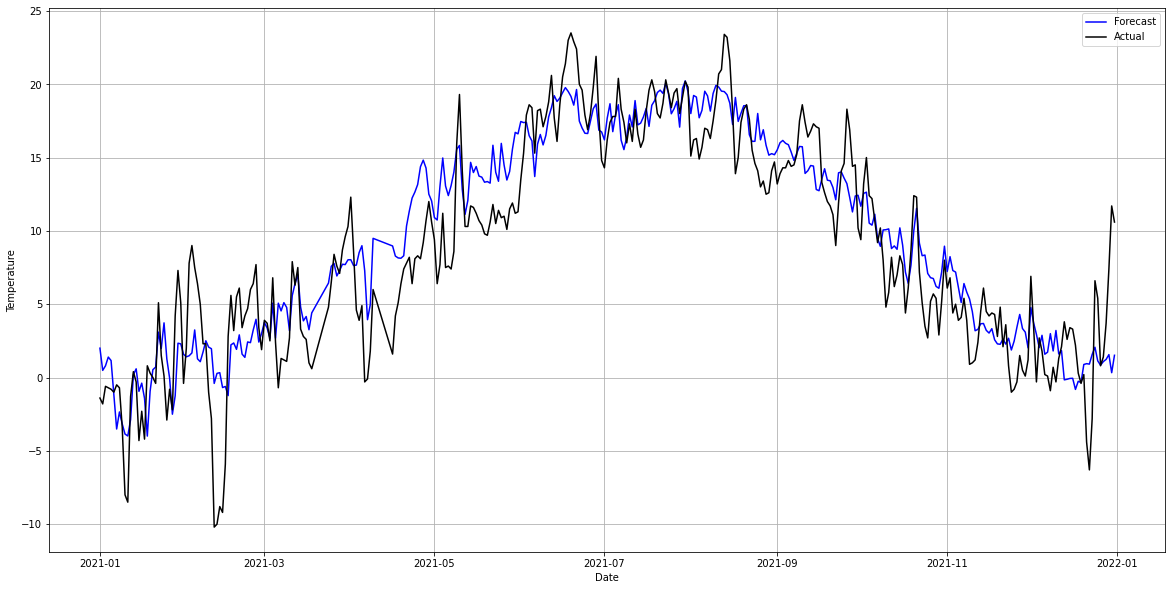

In [92]:
plt.figure(figsize=(20,10))
plt.grid()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(preds['ds'], preds['yhat'], color='blue',  label='Forecast')
plt.plot(preds['ds'], preds['y'], color='black',  label='Actual')
plt.legend()
plt.show()